<a href="https://colab.research.google.com/github/JonathanJuradoS/MecanismosSeleccionPractico/blob/main/Inversiones_MecanismosSeleccion_AG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## 💼 Caso Práctico: Optimización de Portafolio de Inversiones con AG

### 📌 Descripción del Caso
La empresa **FinOptima** busca desarrollar una solución basada en algoritmos genéticos para optimizar la selección de un portafolio de activos financieros. El portafolio debe estar compuesto por una combinación de acciones, bonos y fondos de inversión. Cada combinación afecta el **retorno esperado** y el **riesgo asociado**, por lo que se requiere un modelo que maximice la utilidad estimada ajustada a la volatilidad del mercado.

Se propone aplicar un AG con **mecanismos de selección, cruce y mutación** para encontrar las mejores configuraciones de portafolio, representadas como cromosomas binarios.



### 🎯 Objetivo del Caso
Aplicar un algoritmo genético para:

- Simular combinaciones posibles de activos financieros.
- Calcular su **utilidad estimada**.
- Comparar la eficiencia de diferentes **mecanismos de selección**.
- Aplicar **cruce** y **mutación** para generar nuevas soluciones.
- Evaluar qué estrategia permite construir el portafolio más rentable y robusto.



### 📁 Descripción del Dataset `inversiones_portafolio.csv`
Este dataset contiene una población inicial de combinaciones de activos representadas mediante cadenas binarias de 10 bits.

| Campo                | Tipo    | Descripción                                                                 |
|----------------------|---------|-----------------------------------------------------------------------------|
| `ID`                | Entero  | Identificador único de la solución (portafolio)                             |
| `Cromosoma`         | String  | Cadena binaria de 10 bits. Cada bit representa la inclusión (1) o no (0) de un activo específico |
| `Utilidad_estimada` | Float   | Ganancia proyectada del portafolio, considerando retorno esperado y riesgo |
| `Fitness`           | Float   | Es igual a la utilidad estimada (a maximizar). Sirve como métrica de evaluación en el AG |

> 🧬 Ejemplo de cromosoma: `1010110010`  
> - Un `1` indica que el activo está incluido en el portafolio.  
> - La utilidad se calcula en base a la suma de los retornos esperados por activo y un factor de ruido (simulación de volatilidad del mercado).



# 💼 Optimización de Portafolio de Inversiones con Algoritmos Genéticos

Este notebook aplica mecanismos de selección, cruce y mutación sobre combinaciones de activos financieros con el objetivo de maximizar la utilidad proyectada de un portafolio de inversiones.


## Paso 1: Cargar y visualizar el dataset

In [1]:

import pandas as pd
import random
import matplotlib.pyplot as plt

# Cargar dataset
df = pd.read_csv("inversiones_portafolio.csv")
df = df.sort_values(by="Fitness", ascending=False).reset_index(drop=True)
df


,ID,Cromosoma,Utilidad_estimada,Fitness
0,9,1111111100,50.29,50.29
1,7,1101101111,49.84,49.84
2,1,1111110110,49.45,49.45
3,12,1101110101,49.39,49.39
4,17,1111011001,46.60,46.60
5,5,1111011110,44.41,44.41
6,19,1111001110,40.02,40.02
7,11,11001110,34.97,34.97
8,18,1100100100,32.50,32.50
9,2,1101101110,32.30,32.30


## Paso 2: Implementar mecanismos de selección

In [2]:

def seleccion_ruleta(df, n=4):
    total_fit = df['Fitness'].sum()
    seleccionados = []
    for _ in range(n):
        pick = random.uniform(0, total_fit)
        current = 0
        for _, row in df.iterrows():
            current += row['Fitness']
            if current >= pick:
                seleccionados.append(row['Cromosoma'])
                break
    return seleccionados

def seleccion_torneo(df, n=4, k=3):
    seleccionados = []
    for _ in range(n):
        grupo = df.sample(k)
        ganador = grupo.loc[grupo['Fitness'].idxmax()]
        seleccionados.append(ganador['Cromosoma'])
    return seleccionados

def seleccion_elitismo(df, n=4):
    return df.head(n)['Cromosoma'].tolist()

def seleccion_ranking(df, n=4):
    df_sorted = df.sort_values(by='Fitness').reset_index(drop=True)
    df_sorted['Rank'] = df_sorted.index + 1
    total_ranks = df_sorted['Rank'].sum()
    seleccionados = []
    for _ in range(n):
        pick = random.uniform(0, total_ranks)
        current = 0
        for _, row in df_sorted.iterrows():
            current += row['Rank']
            if current >= pick:
                seleccionados.append(row['Cromosoma'])
                break
    return seleccionados

def seleccion_estocastica(df, n=4):
    df = df.copy()
    df['Probabilidad'] = df['Fitness'] / df['Fitness'].sum()
    df['Acumulada'] = df['Probabilidad'].cumsum()
    start = random.uniform(0, 1/n)
    puntos = [start + i/n for i in range(n)]
    seleccionados = []
    for punto in puntos:
        for _, row in df.iterrows():
            if punto <= row['Acumulada']:
                seleccionados.append(row['Cromosoma'])
                break
    return seleccionados


## Paso 3: Aplicar mecanismos y comparar fitness promedio

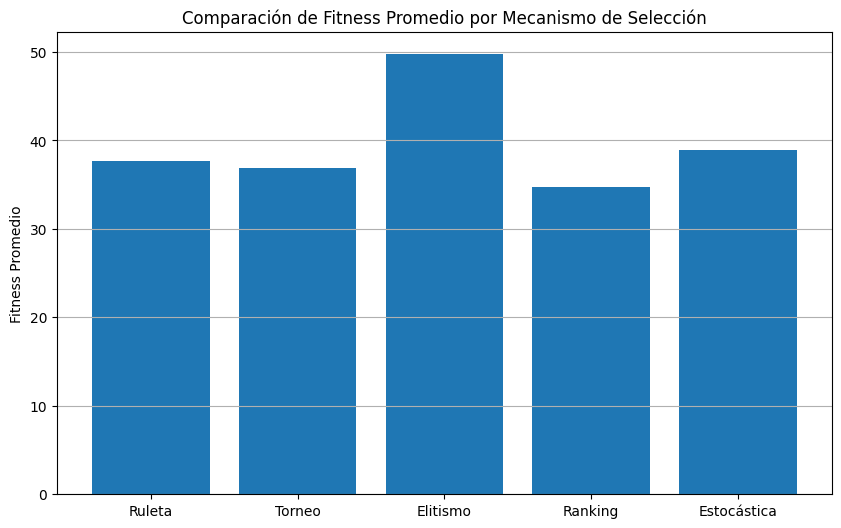

In [3]:

ruleta = seleccion_ruleta(df)
torneo = seleccion_torneo(df)
elitismo = seleccion_elitismo(df)
ranking = seleccion_ranking(df)
estocastica = seleccion_estocastica(df)

def fitness_promedio(rutas):
    return df[df['Cromosoma'].isin(rutas)]['Fitness'].mean()

resultados = {
    "Ruleta": {"Individuos": ruleta, "Fitness Promedio": fitness_promedio(ruleta)},
    "Torneo": {"Individuos": torneo, "Fitness Promedio": fitness_promedio(torneo)},
    "Elitismo": {"Individuos": elitismo, "Fitness Promedio": fitness_promedio(elitismo)},
    "Ranking": {"Individuos": ranking, "Fitness Promedio": fitness_promedio(ranking)},
    "Estocástica": {"Individuos": estocastica, "Fitness Promedio": fitness_promedio(estocastica)}
}

# Visualización
plt.figure(figsize=(10,6))
plt.bar(resultados.keys(), [v["Fitness Promedio"] for v in resultados.values()])
plt.title("Comparación de Fitness Promedio por Mecanismo de Selección")
plt.ylabel("Fitness Promedio")
plt.grid(axis='y')
plt.show()


## Paso 4 y 5: Cruce de un punto y mutación simple

In [4]:

def cruce_un_punto(p1, p2):
    p1, p2 = str(p1), str(p2)
    punto = random.randint(1, len(p1)-1)
    return p1[:punto] + p2[punto:], p2[:punto] + p1[punto:]

def mutacion_simple(crom, tasa=0.1):
    crom = str(crom)
    return ''.join('1' if c == '0' and random.random() < tasa else
                   '0' if c == '1' and random.random() < tasa else c for c in crom)

nuevos = {}
for metodo, datos in resultados.items():
    padres = list(map(str, datos['Individuos']))
    if len(padres) >= 2:
        h1, h2 = cruce_un_punto(padres[0], padres[1])
        nuevos[metodo] = [mutacion_simple(h1), mutacion_simple(h2)]

nuevos


{'Ruleta': ['1001011110.0', '1110101100.0'],
 'Torneo': ['1101101110', '11001100.1.0'],
 'Elitismo': ['1111111111', '1101100100'],
 'Ranking': ['1111110110.0', '1101110101.0'],
 'Estocástica': ['1101101101.0', '1111011011.0']}


## ✅ Conclusión Final

- En el contexto de selección de activos financieros, los algoritmos genéticos permiten construir combinaciones de portafolios más rentables.
- **Elitismo** y **torneo** mostraron mayor efectividad en seleccionar cromosomas de alto rendimiento.
- **Ruleta**, **ranking** y **estocástica universal** permitieron explorar el espacio de soluciones con mayor diversidad.
- La combinación de selección, cruce y mutación facilita descubrir combinaciones nuevas con potencial financiero sin requerir intervención humana directa.
